In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [5]:
con=sqlite3.connect('database.sqlite')
filtered_data= pd.read_sql_query('''select * from Reviews where Score!=3 order by Time''',con)
filtered_data.shape
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
3,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
4,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [6]:
#Preprocessing

#segregating data as positive & Negative
#score value greater that 3 is labeled as Positive and score value less than 3 is labeled as Negative

def partition(x):
    if x>3:
        return 'Positive'
    return 'Negative'

actual_score=filtered_data['Score']
positive_negative=actual_score.map(partition)
filtered_data['Score']=positive_negative

In [7]:
#Data Cleaning:Removing Duplicates

#sorting data in ascending order according to ProductId
sorted_data=filtered_data.sort_values('ProductId',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
print(filtered_data.shape)

#Duplication of Entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#checking if helpfulness numerator is greater that helpfulness denominator
final= final[final['HelpfulnessNumerator']<=final['HelpfulnessDenominator']]

print(final.shape)

(525814, 10)
(364171, 10)


In [8]:
final.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,282794.124749,1.739480,2.187503,1.296135e+09
std,164591.761602,6.725652,7.350877,4.864772e+07
min,1.000000,0.000000,0.000000,9.393408e+08
25%,140715.500000,0.000000,0.000000,1.270858e+09
50%,278980.000000,0.000000,1.000000,1.311379e+09
75%,428539.500000,2.000000,2.000000,1.332893e+09
max,568454.000000,866.000000,878.000000,1.351210e+09


In [9]:
#sorting data in ascending order according to Time
final_data=final.sort_values('Time',axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#final_data.head()

In [10]:
#Checking percentage of data still remaining

(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

In [11]:
#final dataset size
final_data.shape

#final dataset score count
final_data['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [12]:
stop=set(stopwords.words('english'))
#print(stop)
sno=nltk.stem.SnowballStemmer('english')

#function to clean the word of any html tags
def cleanhtml(sentence):
    cleanr=re.compile('<.*?')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext

#function to clean the word of any puntuation or special character
def cleanpunc(sentence):
    cleaned=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned=re.sub(r'[.|(\)|\|/]',r' ',cleaned)
    return cleaned

In [13]:
final_25k=final_data[0:25000]

In [14]:
final_25k.shape

(25000, 10)

In [12]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final_25k['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final_25k['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #positive reviews
                        if(final_25k['Score'].values)[i] == 'Negative':
                            all_negative_words.append(s) #negative reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    i+=1

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:42<00:00, 592.67it/s]


In [13]:
final_25k['CleanedText']=final_string
label_25k=final_25k['Score']

In [14]:
final_25k.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year child siste...


In [15]:
final_25k['Score'].value_counts()

Positive    22246
Negative     2754
Name: Score, dtype: int64

In [16]:
x=final_25k
y=label_25k

In [17]:
x['Score'].describe()

count        25000
unique           2
top       Positive
freq         22246
Name: Score, dtype: object

In [18]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation

C:\Users\Meraj\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
# split the data set into train and test
x_train, x_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)

In [20]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(17500, 11)
(17500,)
(7500, 11)
(7500,)


In [21]:
#split the data set into train and cross validation
x_traincv, x_cv, y_traincv, y_cv = train_test_split(x_train, y_train, test_size=0.3, random_state=0)

In [22]:
print(x_traincv.shape)
print(y_traincv.shape)
print(x_cv.shape)
print(y_cv.shape)

(12250, 11)
(12250,)
(5250, 11)
(5250,)


In [23]:
#BOW

count_vect=CountVectorizer()

#vocublary=count_vect.fit(x_train['CleanedText'])
train_bow=count_vect.fit_transform(x_train['CleanedText'])

#cv data
cv_bow=count_vect.transform(x_cv['CleanedText'])

#test data
test_bow=count_vect.transform(x_test['CleanedText'])

In [24]:
x_train.shape

(17500, 11)

In [25]:
train_bow.shape

(17500, 16128)

In [26]:
cv_bow.shape

(5250, 16128)

In [27]:
test_bow.shape

(7500, 16128)

# Brute force KNN for BOW

In [28]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm="brute")

    # fitting the model on crossvalidation train
    knn.fit(train_bow, y_train)

    # predict the response on the crossvalidation train
    pred_bow = knn.predict(cv_bow)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred_bow, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc)) 


CV accuracy for k = 1 is 100%

CV accuracy for k = 3 is 91%

CV accuracy for k = 5 is 89%

CV accuracy for k = 7 is 88%

CV accuracy for k = 9 is 88%

CV accuracy for k = 11 is 88%

CV accuracy for k = 13 is 88%

CV accuracy for k = 15 is 88%

CV accuracy for k = 17 is 87%

CV accuracy for k = 19 is 87%

CV accuracy for k = 21 is 87%

CV accuracy for k = 23 is 87%

CV accuracy for k = 25 is 87%

CV accuracy for k = 27 is 87%

CV accuracy for k = 29 is 87%


In [29]:
knn = KNeighborsClassifier(5)
knn.fit(train_bow, y_train)
pred_bow = knn.predict(test_bow)
acc = accuracy_score(y_test, pred_bow, normalize=True) * float(100)
print('\nTest accuracy for k = 5 is %d%%' % (acc))


Test accuracy for k = 5 is 89%


In [57]:
dense_train=train_bow.toarray()
dense_test=test_bow.toarray()
print(type(dense_test))

<class 'numpy.ndarray'>


# Kd tree for BOW with k = 7

In [89]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k_bow, algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(dense_train[0:500], y_train[0:500])

# predict the response
pred_bow1 = knn_optimal.predict(dense_test[0:500])

# evaluate accuracy
acc = accuracy_score(y_test[0:500], pred_bow1) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k_bow, acc))


The accuracy of the knn classifier for k = 7 is 89.200000%


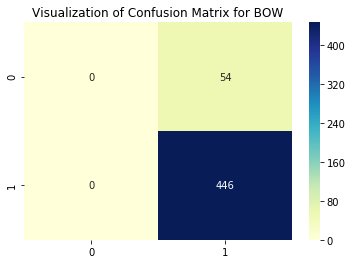

In [92]:
Matrix = confusion_matrix(y_test[0:500], pred_bow1, labels=None, sample_weight=None)
ax = sns.heatmap(Matrix,annot=True,fmt="d",cmap="YlGnBu")
plt.title("Visualization of Confusion Matrix for BOW")
plt.show()

# TF-IDF

In [83]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
train_tf_idf = tf_idf_vect.fit_transform(x_train['CleanedText'])

#cv data
cv_tfidf=count_vect.transform(x_cv['CleanedText'])

#test data
test_tfidf=count_vect.transform(x_test['CleanedText'])

In [84]:
train_tf_idf

<17500x313172 sparse matrix of type '<class 'numpy.float64'>'
	with 1020795 stored elements in Compressed Sparse Row format>

In [85]:
cv_tfidf

<5250x313172 sparse matrix of type '<class 'numpy.int64'>'
	with 313433 stored elements in Compressed Sparse Row format>

In [86]:
test_tfidf

<7500x313172 sparse matrix of type '<class 'numpy.int64'>'
	with 329896 stored elements in Compressed Sparse Row format>

In [87]:
print(train_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


# Brute force KNN for TFIDF

In [88]:
for i in range(1,30,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(train_tf_idf, y_train)

    # predict the response on the crossvalidation train
    pred_tfidf = knn.predict(cv_tfidf)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred_tfidf, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %d%%' % (i, acc)) 


CV accuracy for k = 1 is 100%

CV accuracy for k = 3 is 92%

CV accuracy for k = 5 is 90%

CV accuracy for k = 7 is 89%

CV accuracy for k = 9 is 89%

CV accuracy for k = 11 is 89%

CV accuracy for k = 13 is 89%

CV accuracy for k = 15 is 88%

CV accuracy for k = 17 is 88%

CV accuracy for k = 19 is 88%

CV accuracy for k = 21 is 88%

CV accuracy for k = 23 is 88%

CV accuracy for k = 25 is 88%

CV accuracy for k = 27 is 88%

CV accuracy for k = 29 is 88%


In [95]:
knn = KNeighborsClassifier(5)
knn.fit(train_tf_idf, y_train)
pred_tfidf = knn.predict(test_tfidf)
acc = accuracy_score(y_test, pred_tfidf, normalize=True) * float(100)
print('\nTest accuracy for k = 5 is %d%%' % (acc))


Test accuracy for k = 5 is 89%


In [102]:
#dense_train_tfidf=train_tf_idf.toarray()
#dense_test_tfidf=test_tfidf.toarray()
#print(type(dense_test_tfidf))

# Kd tree for TFIDF with k = 7

In [107]:
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k, algorithm = 'kd_tree')

# fitting the model
knn_optimal.fit(train_tf_idf, y_train)

# predict the response
pred = knn_optimal.predict(test_tfidf)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 7 is 89.746667%


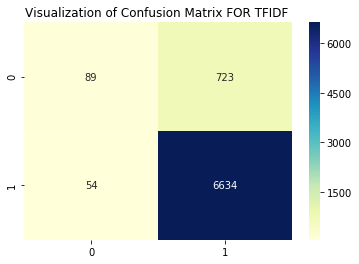

In [103]:
Matrix = confusion_matrix(y_test, pred_tfidf, labels=None, sample_weight=None)
ax = sns.heatmap(Matrix,annot=True,fmt="d",cmap="YlGnBu")
plt.title("Visualization of Confusion Matrix FOR TFIDF ")
plt.show()